In [ ]:
!apt-get install -y fonts-noto || true
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/unhinted/otf/NotoSansBrahmi/NotoSansBrahmi-Regular.otf -O /content/NotoSansBrahmi-Regular.otf
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/unhinted/otf/NotoSansTamil/NotoSansTamil-Regular.otf -O /content/NotoSansTamil-Regular.otf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
dir_path = "/content/drive/MyDrive/DataGenerator/"
os.makedirs(dir_path, exist_ok=True)
print(f"✅ Directory created at: {dir_path}")

ValueError: mount failed

In [ ]:
!wget -q https://raw.githubusercontent.com/AGILAN2005/Tamil_LLM/refs/heads/main/tamil_brahmi_dataset.csv -O /content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset.csv


In [ ]:
import os, re, json, unicodedata
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from PIL import ImageEnhance, ImageOps, ImageFilter, ImageChopsm
from pathlib import Path
from tqdm import tqdm
import cv2

In [ ]:
CSV_FILE = "/content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset.csv"

OUT_DIR = "/content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset"

os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_FILE)

BRAHMI_FONT = "/usr/share/fonts/truetype/noto/NotoSansBrahmi-Regular.ttf"

IMG_SIZE = (512, 128)
FONT_SIZE = 42
BG_COLOR = "white"
TEXT_COLOR = "black"

brahmi_font = ImageFont.truetype(BRAHMI_FONT, FONT_SIZE)

def create_image(text, font, save_path):
    """Create an image from Brahmi text."""
    img = Image.new("RGB", IMG_SIZE, BG_COLOR)
    draw = ImageDraw.Draw(img)
    bbox = draw.textbbox((0, 0), text, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    draw.text(((IMG_SIZE[0]-w)/2, (IMG_SIZE[1]-h)/2), text, font=font, fill=TEXT_COLOR)
    img.save(save_path)


train_df, temp = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, random_state=42)

splits = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}

all_labels = {}


for split_name, split_df in splits.items():
    split_dir = os.path.join(OUT_DIR, split_name)
    os.makedirs(split_dir, exist_ok=True)

    labels = {}
    for idx, row in split_df.reset_index(drop=True).iterrows():
        tamil_text = str(row["tamil"])
        brahmi_text = str(row["brahmi"])

        img_filename = f"{split_name}_{idx:04d}.png"
        img_path = os.path.join(split_dir, img_filename)


        create_image(brahmi_text, brahmi_font, img_path)


        labels[img_filename] = {
            "tamil": tamil_text,
            "brahmi": brahmi_text
        }
        all_labels[img_filename] = labels[img_filename]


    with open(os.path.join(split_dir, "labels.json"), "w", encoding="utf-8") as f:
        json.dump(labels, f, ensure_ascii=False, indent=2)

with open(os.path.join(OUT_DIR, "all_labels.json"), "w", encoding="utf-8") as f:
    json.dump(all_labels, f, ensure_ascii=False, indent=2)

print("✅ Tamil-Brahmi dataset created at:", OUT_DIR)

✅ Tamil-Brahmi dataset created at: /content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset


test: 100%|██████████| 95/95 [00:09<00:00,  9.59it/s]


✅ Augmentation complete. Total images: 10112


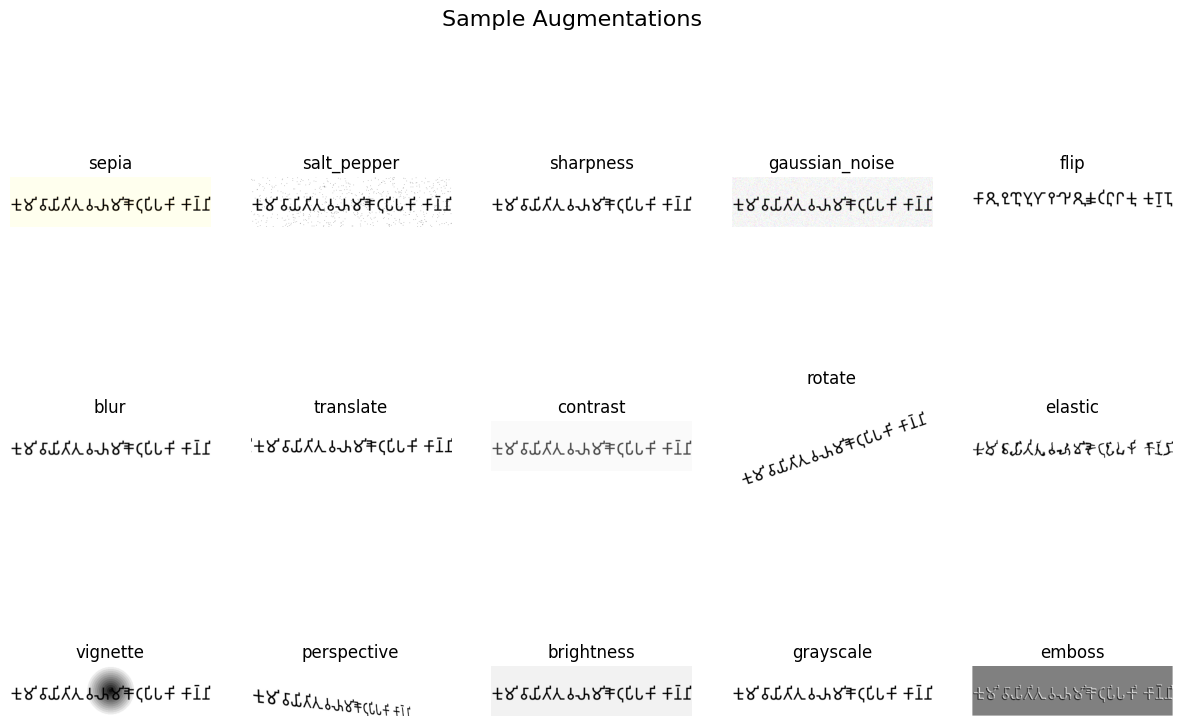

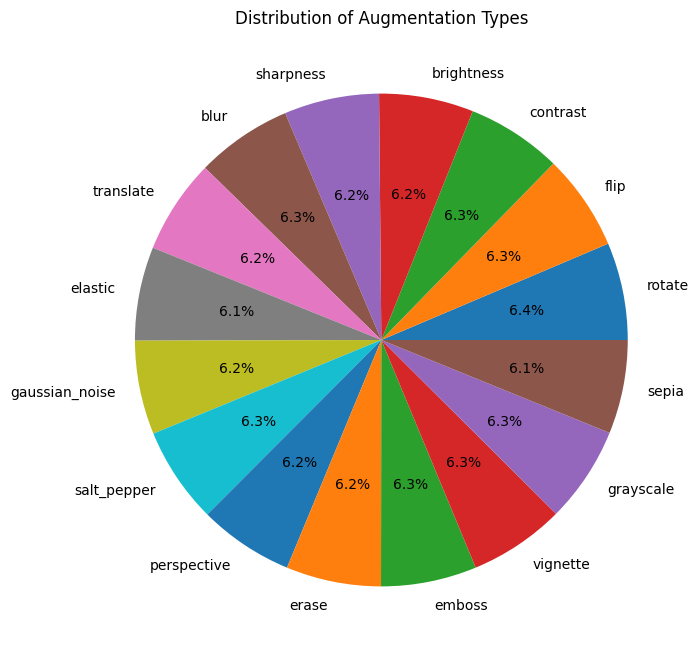

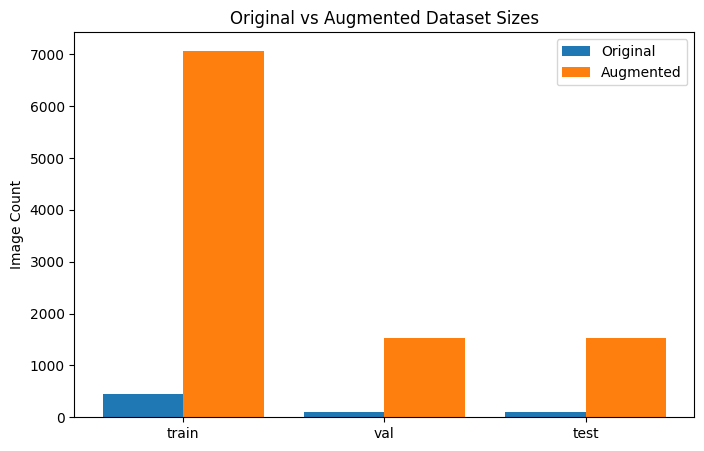


📊 Case Study Summary



,Augmentation,Count,% of Dataset
0,rotate,606,5.99%
1,flip,598,5.91%
2,contrast,593,5.86%
3,brightness,587,5.80%
4,sharpness,591,5.84%
5,blur,598,5.91%
6,translate,588,5.81%
7,elastic,583,5.77%
8,gaussian_noise,584,5.78%
9,salt_pepper,599,5.92%


In [ ]:
import os, random, json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageDraw, ImageChops
import pandas as pd


class TamilBrahmiAugmentor:
    def __init__(self, dataset_dir, output_dir, aug_per_image=15, target_size=(224,224)):
        self.dataset_dir = Path(dataset_dir)
        self.output_dir = Path(output_dir)
        self.aug_per_image = aug_per_image
        self.target_size = target_size
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # All augmentations
        self.augmentations = [
            "rotate", "flip", "contrast", "brightness", "sharpness",
            "blur", "translate", "elastic", "gaussian_noise", "salt_pepper",
            "perspective", "erase", "emboss", "vignette", "grayscale", "sepia"
        ]


    def add_gaussian_noise(self, img):
        arr = np.array(img)
        noise = np.random.normal(0, 25, arr.shape).astype(np.float32)
        noisy = np.clip(arr.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy)

    def add_salt_pepper_noise(self, img):
        arr = np.array(img)
        rnd = np.random.rand(*arr.shape[:2])
        salt_mask = rnd < 0.01
        pepper_mask = rnd > 0.99
        arr[salt_mask] = 255
        arr[pepper_mask] = 0
        return Image.fromarray(arr)

    def elastic_deformation(self, img, alpha=50, sigma=5):
        arr = np.array(img)
        shape = arr.shape[:2]
        dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1) * alpha, (17,17), sigma)
        dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1) * alpha, (17,17), sigma)
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        map_x = (x+dx).astype(np.float32)
        map_y = (y+dy).astype(np.float32)
        return Image.fromarray(cv2.remap(arr, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT))

    def random_perspective(self, img):
        w, h = img.size
        coeffs = (
            1+random.uniform(-0.2,0.2), random.uniform(-0.2,0.2), random.randint(-10,10),
            random.uniform(-0.2,0.2), 1+random.uniform(-0.2,0.2), random.randint(-10,10),
            random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
        )
        return img.transform((w,h), Image.PERSPECTIVE, coeffs, Image.BICUBIC, fillcolor="white")

    def random_erase(self, img):
        arr = np.array(img)
        h,w = arr.shape[:2]
        x1,y1 = random.randint(0,w-20), random.randint(0,h-20)
        x2,y2 = min(w, x1+random.randint(10,30)), min(h, y1+random.randint(10,30))
        arr[y1:y2,x1:x2] = 255
        return Image.fromarray(arr)

    def vignette(self, img):
        w,h = img.size
        mask = Image.new("L",(w,h),255)
        draw = ImageDraw.Draw(mask)
        for r in range(min(w,h)//2,0,-5):
            alpha = int(255*(r/(min(w,h)//2)))
            draw.ellipse((w//2-r,h//2-r,w//2+r,h//2+r),fill=alpha)
        return ImageChops.multiply(img, Image.merge("RGB",(mask,mask,mask)))

    def sepia(self, img):
        arr = np.array(img,dtype=np.float64)
        sepia_filter = np.array([[0.393,0.769,0.189],
                                 [0.349,0.686,0.168],
                                 [0.272,0.534,0.131]])
        arr = arr@sepia_filter.T
        return Image.fromarray(np.clip(arr,0,255).astype(np.uint8))

    def apply(self, img, aug_type):
        if aug_type=="rotate":
            return img.rotate(random.uniform(-25,25), expand=True, fillcolor="white")
        if aug_type=="flip":
            return random.choice([ImageOps.mirror(img), ImageOps.flip(img)])
        if aug_type=="contrast":
            return ImageEnhance.Contrast(img).enhance(random.uniform(0.7,1.3))
        if aug_type=="brightness":
            return ImageEnhance.Brightness(img).enhance(random.uniform(0.7,1.3))
        if aug_type=="sharpness":
            return ImageEnhance.Sharpness(img).enhance(random.uniform(0.5,2.5))
        if aug_type=="blur":
            return img.filter(ImageFilter.GaussianBlur(random.uniform(0.2,1.5)))
        if aug_type=="translate":
            return ImageChops.offset(img, random.randint(-10,10), random.randint(-10,10))
        if aug_type=="elastic":
            return self.elastic_deformation(img)
        if aug_type=="gaussian_noise":
            return self.add_gaussian_noise(img)
        if aug_type=="salt_pepper":
            return self.add_salt_pepper_noise(img)
        if aug_type=="perspective":
            return self.random_perspective(img)
        if aug_type=="erase":
            return self.random_erase(img)
        if aug_type=="emboss":
            return img.filter(ImageFilter.EMBOSS)
        if aug_type=="vignette":
            return self.vignette(img)
        if aug_type=="grayscale":
            return ImageOps.grayscale(img).convert("RGB")
        if aug_type=="sepia":
            return self.sepia(img)
        return img


    def augment_dataset(self):
        all_labels = {}
        aug_counts = {aug:0 for aug in self.augmentations}

        for split in ["train","val","test"]:
            split_dir = self.dataset_dir/split
            out_dir = self.output_dir/split
            out_dir.mkdir(parents=True, exist_ok=True)
            labels_path = split_dir/"labels.json"
            if not labels_path.exists(): continue
            labels = json.load(open(labels_path,"r",encoding="utf-8"))

            split_labels={}
            for img_file, meta in tqdm(labels.items(),desc=f"{split}"):
                img = Image.open(split_dir/img_file).convert("RGB")
                img.save(out_dir/img_file)
                split_labels[img_file] = meta
                all_labels[img_file] = meta

                chosen_augs = random.sample(self.augmentations, min(self.aug_per_image, len(self.augmentations)))
                for aug in chosen_augs:
                    aug_img = self.apply(img, aug)
                    new_name = img_file.replace(".png", f"_{aug}.png")
                    aug_img.save(out_dir/new_name)
                    split_labels[new_name] = meta
                    all_labels[new_name] = meta
                    aug_counts[aug]+=1

            json.dump(split_labels, open(out_dir/"labels.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)

        json.dump(all_labels, open(self.output_dir/"all_labels.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)
        print(f"✅ Augmentation complete. Total images: {len(all_labels)}")
        return all_labels, aug_counts


def visualize_sample_augmentations(augmentor, sample_img_path):
    img = Image.open(sample_img_path).convert("RGB")
    fig, axes = plt.subplots(3,5, figsize=(15,9))
    chosen_augs = random.sample(augmentor.augmentations, 15)
    for ax, aug in zip(axes.flatten(), chosen_augs):
        aug_img = augmentor.apply(img, aug)
        ax.imshow(aug_img)
        ax.set_title(aug)
        ax.axis("off")
    plt.suptitle("Sample Augmentations", fontsize=16)
    plt.show()

def visualize_distribution(aug_counts):
    plt.figure(figsize=(8,8))
    plt.pie(aug_counts.values(), labels=aug_counts.keys(), autopct="%1.1f%%")
    plt.title("Distribution of Augmentation Types")
    plt.show()

def visualize_dataset_sizes(dataset_dir, output_dir):
    sizes = {}
    for split in ["train","val","test"]:
        orig = len(json.load(open(Path(dataset_dir)/split/"labels.json")))
        aug = len(json.load(open(Path(output_dir)/split/"labels.json")))
        sizes[split] = (orig, aug)
    x = np.arange(len(sizes))
    orig_sizes = [sizes[s][0] for s in sizes]
    aug_sizes = [sizes[s][1] for s in sizes]
    plt.figure(figsize=(8,5))
    plt.bar(x-0.2, orig_sizes, width=0.4, label="Original")
    plt.bar(x+0.2, aug_sizes, width=0.4, label="Augmented")
    plt.xticks(x, sizes.keys())
    plt.ylabel("Image Count")
    plt.title("Original vs Augmented Dataset Sizes")
    plt.legend()
    plt.show()


def case_study_table(aug_counts, all_labels):
    print("\n📊 Case Study Summary\n")
    total_imgs = len(all_labels)
    table_data = []
    for aug, count in aug_counts.items():
        table_data.append([aug, count, f"{(count/total_imgs)*100:.2f}%"])
    df_table = pd.DataFrame(table_data, columns=["Augmentation","Count","% of Dataset"])
    display(df_table)


dataset_dir = "/content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset"
output_dir = "tamil_brahmi_augmented"

augmentor = TamilBrahmiAugmentor(dataset_dir, output_dir, aug_per_image=15)
all_labels, aug_counts = augmentor.augment_dataset()


sample_img_path = next((Path(dataset_dir)/"train").glob("*.png"))
visualize_sample_augmentations(augmentor, sample_img_path)
visualize_distribution(aug_counts)
visualize_dataset_sizes(dataset_dir, output_dir)

case_study_table(aug_counts, all_labels)

In [ ]:
import json
from pathlib import Path

dataset_dir = "/content/drive/MyDrive/DataGenerator/tamil_brahmi_dataset"
output_dir = "tamil_brahmi_augmented"

def count_images(directory):
    if Path(directory).exists():
        return len(list(Path(directory).glob("**/*.png")))
    return 0

original_counts = {}
augmented_counts = {}
total_original = 0
total_augmented = 0

for split in ["train", "val", "test"]:
    original_split_dir = Path(dataset_dir) / split
    augmented_split_dir = Path(output_dir) / split

    original_count = count_images(original_split_dir)
    augmented_count = count_images(augmented_split_dir)

    original_counts[split] = original_count
    augmented_counts[split] = augmented_count

    total_original += original_count
    total_augmented += augmented_count

print("📊 Dataset Image Counts:")
print("-" * 30)
print(f"{'Split':<10} | {'Original':<10} | {'Augmented':<10}")
print("-" * 30)
for split in ["train", "val", "test"]:
    print(f"{split:<10} | {original_counts[split]:<10} | {augmented_counts[split]:<10}")
print("-" * 30)
print(f"{'Total':<10} | {total_original:<10} | {total_augmented:<10}")

📊 Dataset Image Counts:
------------------------------
Split      | Original   | Augmented 
------------------------------
train      | 442        | 7072      
val        | 95         | 1520      
test       | 95         | 1520      
------------------------------
Total      | 632        | 10112     


In [ ]:
import json

def create_character_map():
    """
    Creates a JSON file mapping Tamil-Brahmi characters to modern Tamil
    with unique integer IDs for use in ML models.
    """
    # Data extracted from the image (Brahmi, Tamil)
    vowels_data = [
        ("𑀅", "அ"), ("𑀆", "ஆ"), ("𑀇", "இ"), ("𑀈", "ஈ"), ("𑀉", "உ"),
        ("𑀊", "ஊ"), ("𑀏", "எ"), ("𑀐", "ஏ"), ("𑀎", "ஐ"), ("𑀑", "ஒ"),
        ("𑀒", "ஓ"), ("𑀐𑀅", "ஔ")
    ]

    special_char_data = [
        ("𑀂", "ஃ")
    ]

    consonants_data = [
        ("𑀓", "க"), ("𑀗", "ங"), ("𑀘", "ச"), ("𑀜", "ஞ"), ("𑀝", "ட"),
        ("𑀡", "ண"), ("𑀢", "த"), ("𑀦", "ந"), ("𑀧", "ப"), ("𑀫", "ம"),
        ("𑀬", "ய"), ("𑀭", "ர"), ("𑀮", "ல"), ("𑀯", "வ"), ("𑀵", "ழ"),
        ("𑀴", "ள"), ("𑀶", "ற"), ("𑀷", "ன")
    ]

    char_map = {}
    current_id = 0

    # Process vowels
    char_map["vowels"] = []
    for brahmi, tamil in vowels_data:
        char_map["vowels"].append({"id": current_id, "brahmi": brahmi, "tamil": tamil})
        current_id += 1

    # Process special characters
    char_map["special_characters"] = []
    for brahmi, tamil in special_char_data:
        char_map["special_characters"].append({"id": current_id, "brahmi": brahmi, "tamil": tamil})
        current_id += 1

    # Process consonants
    char_map["consonants"] = []
    for brahmi, tamil in consonants_data:
        char_map["consonants"].append({"id": current_id, "brahmi": brahmi, "tamil": tamil})
        current_id += 1

    # Create final structure with metadata
    final_structure = {
        "metadata": {
            "description": "Vocabulary map for Tamil-Brahmi base characters.",
            "source": "image_468306.jpg",
            "total_characters": current_id
        },
        **char_map
    }

    # Save the file
    output_filename = "character_map.json"
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(final_structure, f, ensure_ascii=False, indent=2)

    print(f"✅ Character map successfully created at: {output_filename}")


if __name__ == "__main__":
    create_character_map()

✅ Character map successfully created at: character_map.json
